In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings
from statsmodels.stats.diagnostic import het_white
from linearmodels import PanelOLS
from linearmodels.iv import IV2SLS
from patsy import dmatrices
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from linearmodels.panel import compare

# Silencing future warnings to remove clutter
warnings.filterwarnings("ignore", category=FutureWarning)

# Step 4: Economic Analysis
## Question 1: Is there evidence of the Kuznets hypothesis when examining the effect between GDP growth and inequality?
We define the equation as:

$$
\begin{aligned}
\overline{\text{GDP\_Growth}}_{i}
&= \beta_0
+ \beta_1 \,\overline{\text{Gini}}_{i}
+ \beta_2 \,\overline{\text{Gini}}^{\,2}_{i}
+ \beta_3 \log(\overline{\text{GDP\_Pc}}_{i})
+ \beta_4 \log(\overline{\text{Educ\_Exp}}_{i}) \\
&\quad
+ \beta_5 \log(\overline{\text{Trade}}_{i})
+ \beta_6 \,\overline{\text{Govt\_Effectiveness}}_{i}
+ \beta_7 \left(\overline{\text{Educ\_Exp}}_{i} \times \overline{\text{Govt\_Effectiveness}}_{i}\right)
+ \text{ε}_{i}
\end{aligned}
$$

Our dependent variable here is GDP growth and the main explanatory variables are Gini and Gini squared. Here we aim to find the **between** country effect, we define a time period [2015-2019] and take the average of all variables over this period. This fixed the time variable and turns the panel into a cross-section.

In [2]:
# Statistical significance helper function
def stat_significance(est):
    p_values = est.pvalues
    for feature, p in p_values.items():
        if p <= 0.01:
            print(f"{feature}: {p} -- Reject at 1% significance level\n")
        elif p <= 0.05:
            print(f"{feature}: {p} -- Reject at 5% significance level\n")
        elif p<= 0.1:
            print(f"{feature}: {p} -- Reject at 10% significance level\n")
        else:
            print(f"{feature}: {p} -- Fail to reject at 10% significance level\n")


In [3]:
# Question 1
# Reading averaged dataframe
wb_avg = pd.read_csv('data/wb_avg.csv')
# Setting up formula
formula_1 = (""
           "GDP_Growth ~ Gini_Index + Gini_Sq + "
           "GDP_Pc_Log + Educ_Log + Trade_Log + "
             "Govt_Effectiveness +"
             "Educ_Govt_Eff"
             )

# List of variables on which to drop rows (interaction excluded)
vars_1 = ['GDP_Growth', 'Gini_Index', 'Gini_Sq',
        'GDP_Pc_Log', 'Educ_Log', 'Trade_Log',
          'Govt_Effectiveness']

# Rows before
before = wb_avg.shape[0]

# Dropping only regression variable subset - listwise deletion
wb_q1 = wb_avg.dropna(subset=vars_1)

# Rows after
after = wb_q1.shape[0]

# Expressing rows dropped as percentage
per_dropped = ((before - after) / before ) * 100
print(f"We dropped {per_dropped:.2f}% rows")

# Creating design matrices
y, X = dmatrices(formula_1, data=wb_q1, return_type='dataframe')

# Defining OLS model
model_1 = sm.OLS(y, X)

# Estimating
estimate_1 = model_1.fit()

print(estimate_1.summary())

stat_significance(estimate_1)

We dropped 20.93% rows
                            OLS Regression Results                            
Dep. Variable:             GDP_Growth   R-squared:                       0.277
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     8.870
Date:                Fri, 26 Dec 2025   Prob (F-statistic):           3.16e-09
Time:                        11:00:05   Log-Likelihood:                -376.89
No. Observations:                 170   AIC:                             769.8
Df Residuals:                     162   BIC:                             794.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept    

# Summary Table Interpretation
Partial equation of key variables:
$$
\begin{aligned}
\frac{\partial\, \widehat{\text{GDP\_Growth}}}{\partial\, \text{Gini}}
&= \beta_{1} + 2\beta_{2}\,\text{Gini} \\
&= 0.214 + 2(-0.00289)\,\text{Gini}
\end{aligned}
$$
We can find the turning point:
$$
\begin{aligned}
0.214 + 2(-0.00289)\,\text{Gini} = 0 \\
\text{Gini} = 37.04
\end{aligned}
$$
GDP Growth is rising in Gini but at a decreasing rate. It starts falling after the turning point. Interpretation: (i) in very equal societies increasing inequality can increase GDP Growth, (ii) in less equal societies increasing inequality can increase GDP Growth by less, (iii) at the turning point, every subsequent increase will lead to lower growth.

Of note here is that the two variables are not statistically significant at 10% significance level. We will explore why.

# 1a. Is the inference reliable?
We need to test if the residuals are heteroskedastic. We use White's test and confidently reject the null of homoskedasticity at a 0.01% level of significance. We fit the model again with robust standard errors.

In [4]:
## Testing for heteroskedasticity

# White's test
lm_stat, lm_p, f_stat, f_p = het_white(estimate_1.resid, X)

print(f"White LM P-value: {lm_p}")
print(f"White F-test P-value: {f_p}")
# We reject the null of homoskedasticity at all levels of significance

# Estimating with robust standard errors
estimate_robust = model_1.fit(cov_type='HC1')

# Comparing robust results with homoskedastic in a dataframe
comparative_df = pd.DataFrame({
    "Coeff" : estimate_1.params,
    "SE_Homoskedastic" : estimate_1.bse,
    "SE_Robust" : estimate_robust.bse,
    "t_Homoskedastic" : estimate_1.tvalues,
    "t_Robust" : estimate_robust.tvalues,
    "p_Homoskedastic" : estimate_1.pvalues,
    "p_Robust" : estimate_robust.pvalues
})
# Applying map to format all values to 3sf on every column
for col in comparative_df.columns:
    comparative_df[col] = comparative_df[col].map('{:.3g}'.format)
comparative_df

White LM P-value: 9.193359556986812e-09
White F-test P-value: 1.2436160999954316e-14


,Coeff,SE_Homoskedastic,SE_Robust,t_Homoskedastic,t_Robust,p_Homoskedastic,p_Robust
Intercept,13.7,5.11,5.12,2.67,2.67,0.00833,0.00762
Gini_Index,0.214,0.18,0.141,1.18,1.52,0.238,0.129
Gini_Sq,-0.00288,0.00215,0.00159,-1.34,-1.82,0.182,0.0693
GDP_Pc_Log,-1.77,0.258,0.296,-6.85,-5.98,1.42e-10,2.17e-09
Educ_Log,-1.2,0.519,0.491,-2.32,-2.44,0.0218,0.0145
Trade_Log,0.656,0.367,0.387,1.79,1.69,0.0759,0.0902
Govt_Effectiveness,2.99,0.55,0.782,5.44,3.82,1.97e-07,0.000132
Educ_Govt_Eff,-0.375,0.239,0.215,-1.57,-1.74,0.119,0.0815


+ Coefficients don't change, SEs and t-tests do
+ SEs for some variables are increasing, less statistically significant
+ Gini SE decreased, more statistically significant

# 1b. Does inequality and its non-linear transformation jointly influence growth?
Testing the joint hypothesis that the coefficients of Gini and Gini Squared are significantly different form 0.
$$
\begin{aligned}
H_{0}: \beta_{\text{Gini}} = 0 \ \text{and}\ \beta_{\text{Gini}^2} = 0 \\
H_{1}: \beta_{\text{Gini}} \neq 0 \ \text{or}\ \beta_{\text{Gini}^2} \neq 0
\end{aligned}
$$

In [5]:
F_results = estimate_robust.f_test("Gini_Index = 0, Gini_Sq = 0")
print(F_results)

<F test: F=3.046342912796824, p=0.05026457803441033, df_denom=162, df_num=2>


We reject the null at 10% significance level. There is some evidence that they jointly affect growth

# 1c. Is inequality's effect on GDP Growth non-linear?
Testing the hypothesis that the coefficient on Gini squared is significantly different from 0:
$$
\begin{aligned}
H_{0}: \beta_{\text{Gini}^2} = 0 \\
H_{1}: \beta_{\text{Gini}^2} \neq 0
\end{aligned}
$$

In [6]:
t_results = estimate_robust.t_test("Gini_Sq = 0")
print(t_results)

                             Test for Constraints                             
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
c0            -0.0029      0.002     -1.817      0.069      -0.006       0.000


We can reject the null at 10% confidence level. There is evidence that the effect of Gini on Growth is non-linear.

# 1d. Why were inference tests in our summary table unreliable?
Gini and Gini squared are almost perfectly colinear, making the OLS estimator imprecise. The joint F-test used their combined variation combined to explain the variation in the dependent variable. This couldn't be done individually since they were close to perfect correlation. We calculate the correlation of the two variables in the next code cell:

In [7]:
corr_gini = wb_q1['Gini_Index'].corr(wb_q1['Gini_Sq'])
print(corr_gini)

0.9905074992627813


## Question 2: Does greater international trade integration **within a country** lead to higher FDI inflows **over time**?
We define:
$$
\begin{aligned}
\log(\text{FDI}_{it})
&= \beta_0
+ \beta_1 \log(\text{Trade}_{it})
+ \beta_2 \log(\text{GDP\_Pc}_{it})
+ \beta_3 \,\text{Gini}_{it}
+ \beta_4 \,\text{Gini}^2_{it}
+ \beta_5 \,\text{Reg\_Quality}_{it}
\\[1em]
&\quad
+ \beta_6 \left( \text{Reg\_Quality}_{it} \times \log(\text{GDP\_Pc}_{it}) \right)
+ \beta_7 \left( \log(\text{Trade}_{it}) \times \text{Reg\_Quality}_{it} \right)
+  \text{α}_{i}
+  \text{λ}_{t}
+ \text{ε}_{it}
\end{aligned}
$$

We estimate the **within** country effect, with fixed effects. We have both entity and time FEs.

In [8]:
# Question 2

# Reading imputed dataset
wb_imputed = pd.read_csv('data/wb_imputed_final.csv')
# Setting up formula
formula_2 = (""
           "FDI_Log ~ Trade_Log + GDP_Pc_Log + "
           "Gini_Index + Gini_Sq + Reg_Quality + "
             "GDP_RegQ + Trade_RegQ"
             )

# List of variables on which to drop rows (interaction excluded)
vars_2 = ['FDI_Log', 'Trade_Log', 'GDP_Pc_Log',
        'Gini_Index', 'Gini_Sq', 'Reg_Quality',
          'GDP_RegQ', 'Trade_RegQ']

# Rows before
before = wb_imputed.shape[0]

# Dropping only regression variable subset - listwise deletion
wb_q2 = wb_imputed.dropna(subset=vars_2)

# Setting multi-index
wb_q2 = wb_q2.set_index(['iso3', 'year'])

# Rows after dropping missing values
after = wb_q2.shape[0]

# Expressing rows dropped as percentage
per_dropped = ((before - after) / before ) * 100
print(f"We dropped {per_dropped:.2f}% rows")

# Creating design matrices
y, X = dmatrices(formula_2, data=wb_q2, return_type='dataframe')

# Defining OLS model
model_2 = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)

# Estimating
estimate_2 = model_2.fit(cov_type='clustered', cluster_entity=False)

print(estimate_2.summary)

stat_significance(estimate_2)

We dropped 20.69% rows
                          PanelOLS Estimation Summary                           
Dep. Variable:                FDI_Log   R-squared:                        0.0159
Estimator:                   PanelOLS   R-squared (Between):              0.0832
No. Observations:                3581   R-squared (Within):               0.0241
Date:                Fri, Dec 26 2025   R-squared (Overall):              0.0448
Time:                        11:00:09   Log-likelihood                   -5094.4
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      7.7780
Entities:                         174   P-value                           0.0000
Avg Obs:                       20.580   Distribution:                  F(7,3380)
Min Obs:                       5.0000                                           
Max Obs:                       21.000   F-statistic (robust):             9.4039
     

# Summary Table Interpretation
Both key variables $[log(Trade), log(Trade*RegQ)]$ are statistically significant. Taking the partial derivative:
$$
\begin{aligned}
\frac{\partial \log(\text{FDI}_{it})}{\partial \log(\text{Trade}_{it})}
&= \beta_1 + \beta_7\,\text{Reg\_Quality}_{it}. \\
&= 0.4006 - 0.3582\, \text{Reg\_Quality}_{it}
\end{aligned}
$$
 There is a turning point at:
$$
\begin{aligned}
0.4006 - 0.3582\,\text{Reg\_Quality}_{it} &= 0 \\[0.5em]
\text{Reg\_Quality}_{it} &= \frac{0.4006}{0.3582} \approx 1.12
\end{aligned}
$$
We are controlling for time-invariant country characteristics and global shocks. FDI is increasing in trade openness **within** a country, but the magintude relies on regulatory quality. A 1% increase in trade open. increases FDI by 0.4%, if regulatory quality is 0. Each one-unit increase in Reg. Quality reduces the elasticity between trade open. and FDI by 0.36 percentage points.After the turning point, the effect of Trade on FDI becomes negative

Increases in trade openness raise FDI inflows relative to a country's past if it's regulatory quality is weak. As its reg. quality increases the effect diminishes and eventually reverses.

# 2a. What is the interpretation of the fixed effect constants?


In [9]:
# Extracting fixed effects
effects_est = estimate_2.estimated_effects

# Printing first few rows
print(effects_est.head(20))

           estimated_effects
iso3 year                   
AFG  2002          -0.656935
     2003          -0.641077
     2004          -0.466811
     2005          -0.336210
     2006          -0.081283
     2007           0.033667
     2008          -0.098895
     2009          -0.376883
     2010          -0.398995
     2011          -0.246179
     2012          -0.279295
     2013          -0.463510
     2014          -0.441084
     2015          -0.427937
     2016          -0.414770
     2017          -0.455054
     2018          -0.641817
     2019          -0.539043
     2020          -0.971656
     2021          -0.450024


The estimated effect values are capturing: (i) time-invariant country characteristics, e.g. history, culture, geography, and (ii) global shocks that vary through time, such as recessions and crises (e.g. Covid-19). Time fixed effects are causing the value to oscillate around the country FE constant.

# 2b. Is the model overfitting?
We will check if the model is overidentified using LASSO variable selection. Firstly we need to demean the data to remove country and time fixed effects:
$$
\begin{align}
\tilde{y}_{it} = y_{it} - \overline{y}_{i} - \overline{y}_{t} + \overline{y}
\\[1em]
\tilde{x}_{it} = x_{it} - \overline{x}_{i} - \overline{x}_{t} + \overline{x}
\end{align}
$$

We then run LASSO cross-validation to discover the optimal penalty value, alpha. Finally, we run the LASSO model using the penalty and interpret the coefficient selection.

## Demeaning Helper Function

In [10]:
# Generalised demeaning helper function
# Declaring helper demeaning function to re-use
def demean_2FE(df):
    # Copying dataframe
    df_fe = df.copy()
    # Looping over all columns
    for col in df.columns:
        # Grouping by FE type and and create mean vector
        e_mean = df_fe[col].groupby(level='iso3').transform('mean')
        t_mean = df_fe[col].groupby(level='year').transform('mean')
        total_mean = df_fe[col].mean()
        # Demeaning
        df_fe[col] = df_fe[col] - e_mean - t_mean + total_mean
    return df_fe

## Calculating LASSO

The penalty selected through cross-validation is 0.002452577153186399

Trade_Log      0.075532
GDP_Pc_Log    -0.002693
Gini_Index     0.000000
Gini_Sq       -0.012081
Reg_Quality    0.254531
GDP_RegQ      -0.021059
Trade_RegQ    -0.213069
dtype: float64 



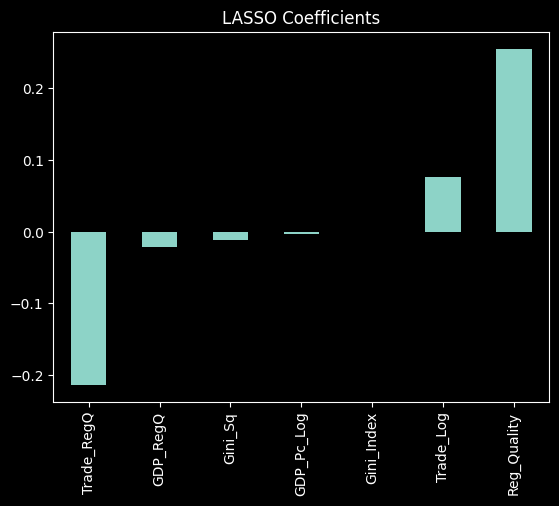

In [11]:
## Testing for Robustness using LASSO

# Combining X and y
df_dm = pd.concat([y, X], axis=1)

# Applying demeaning function to df
df_dm = demean_2FE(df_dm)

# Listwise deletion of empty value rows
df_dm = df_dm.dropna(how='any')

# Splitting into X by taking all rows and all columns less the first
X_2FE = df_dm.iloc[:, 1:]

# Splitting into y by taking all rows and first column
y_2FE = df_dm.iloc[:, 0]

# Dropping intercept column
X_2FE = X_2FE.drop(columns=['Intercept'])

# Standardising X
X_std = (X_2FE - X_2FE.mean()) / X_2FE.std()

# Running LASSO cross-validation to find penalty
Lasso_cv = LassoCV(cv=5, random_state=0)
estimate_cv = Lasso_cv.fit(X_std, y_2FE)

# Defining penalty variable
penalty = estimate_cv.alpha_
print(f"The penalty selected through cross-validation is {penalty}\n")

# Running Lasso model
Lasso_model = linear_model.Lasso(alpha=penalty)
estimate_lasso = Lasso_model.fit(X_std, y_2FE)

# Extracting coefficient series
coefs = pd.Series(estimate_lasso.coef_, index=X_2FE.columns)
print(coefs, "\n")

# Plotting coefficients
coefs.sort_values().plot(kind='bar')
plt.title("LASSO Coefficients")
plt.show()

# LASSO Coefficients
Variables with higher coefficients are deemed to have more explanatory power by LASSO. Linear Gini was dropped, we re-fit the values without Gini:

In [12]:
# Defining post-Lasso dataframe by dropping Gini
X_post = X.drop(columns=['Gini_Index'])

# Running Panel OLS
model_2b = PanelOLS(y, X_post, entity_effects=True, time_effects=True, drop_absorbed=True)
estimate_2b = model_2b.fit(cov_type='clustered', cluster_entity=False)


# Comparing the two results
comparative_table = compare({
    'Pre-LASSO OLS' : estimate_2,
    'Post-LASSO OLS' : estimate_2b
})
print(comparative_table)
stat_significance(estimate_2b)

                  Model Comparison                  
                        Pre-LASSO OLS Post-LASSO OLS
----------------------------------------------------
Dep. Variable                 FDI_Log        FDI_Log
Estimator                    PanelOLS       PanelOLS
No. Observations                 3581           3581
Cov. Est.                   Clustered      Clustered
R-squared                      0.0159         0.0154
R-Squared (Within)             0.0241         0.0233
R-Squared (Between)            0.0832         0.0909
R-Squared (Overall)            0.0448         0.0457
F-statistic                    7.7780         8.8090
P-value (F-stat)               0.0000         0.0000
=====================     ===========    ===========
Intercept                     -1.3160         0.9389
                            (-0.4891)       (0.7180)
Trade_Log                      0.4006         0.3971
                             (2.6679)       (2.6575)
GDP_Pc_Log                    -0.0691        -

# Interpretation of LASSO selection model results
Our key metric is R squared, it largely remains the same and the coefficients remain stable. This is evidence that the model was overfitting Pre-LASSO, none of its explanatory power was lost when Gini was dropped.

## Question 3: Does higher spending on education **within a country** translate to increased growth?
We define:
$$
\begin{aligned}
\text{GDP\_Growth}_{it}
&= \beta_0
+ \beta_1 \,\text{Educ\_Log}_{it}
+ \beta_2 \,\text{Trade\_Log}_{it}
+ \beta_3 \,\text{Gini\_Index}_{it}
+ \beta_4 \,\text{Gini\_sq}_{it}
+ \beta_5 \,\text{Govt\_Effectiveness}_{it}
\\[1em]
&\quad
+ \beta_6 \left( \text{Educ\_Log}_{it} \times \text{Govt\_Effectiveness}_{it} \right)
+ \alpha_i
+ \lambda_t
+ \varepsilon_{it}
\end{aligned}
$$

We aim to estimate the **within** country effect of education spending on growth, using FEs. Our dependent variable is GDP Growth and our main explanatory variable is the log of Education Spending.

In [13]:
# Question 3

# Setting up formula
formula_3 = (""
           "GDP_Growth ~ Educ_Log + Trade_Log + "
           "Gini_Index + Gini_Sq + Govt_Effectiveness + "
             "Educ_Govt_Eff"
             )

# List of variables on which to drop rows (interaction excluded)
vars_3 = ["GDP_Growth", 'Educ_Log', 'Trade_Log',
          'Gini_Index', 'Gini_Sq', 'Govt_Effectiveness',
          'Educ_Govt_Eff']

# Rows before
before = wb_imputed.shape[0]

# Dropping only regression variable subset - listwise deletion
wb_q3 = wb_imputed.dropna(subset=vars_3)

# Setting multi-index
wb_q3 = wb_q3.set_index(['iso3', 'year'])

# Rows after
after = wb_q3.shape[0]

# Expressing rows dropped as percentage
per_dropped = ((before - after) / before ) * 100
print(f"We dropped {per_dropped:.2f}% rows")

# Creating design matrices
y, X = dmatrices(formula_3, data=wb_q3, return_type='dataframe')

# Defining OLS model
model_3 = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)

# Estimating
estimate_3 = model_3.fit(cov_type='clustered', cluster_entity=False)

print(estimate_3.summary)

stat_significance(estimate_3)

We dropped 21.66% rows
                          PanelOLS Estimation Summary                           
Dep. Variable:             GDP_Growth   R-squared:                        0.0270
Estimator:                   PanelOLS   R-squared (Between):             -1.5838
No. Observations:                3537   R-squared (Within):               0.0401
Date:                Fri, Dec 26 2025   R-squared (Overall):             -0.2160
Time:                        11:00:12   Log-likelihood                -1.007e+04
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      15.443
Entities:                         170   P-value                           0.0000
Avg Obs:                       20.806   Distribution:                  F(6,3341)
Min Obs:                       9.0000                                           
Max Obs:                       21.000   F-statistic (robust):             9.9387
     

# Summary Table Interpretation
The interaction term is statistically insignificant, so the marginal effect of education spending on growth is just $\beta_1 = -1.4678$. A 1% increase in education spending is associated with a -0.0147 **percentage point decrease** in GDP Growth. The interpretation here is not clear yet as we suspect endogeneity. Education Spending and GDP Growth likely exhibit simultaneity as we expect them to be jointly determined.

# 3a. Is there endogeneity and how do we address it?

Endogeneity biases the estimates and makes the OLS estimators inconsistent. A relevant and valid instrument can mitigate this. A candidate instrument is the lag of Education Expenditure. We assume past education spending only affects current economic growth through current education spending. We also expect for current education spending to be related to past spending.

IV for Education Expenditure:
$Z_{1, it} = \text{Educ\_Log}_{i(t-1)}$

IV Interaction Term:
$
Z_{2, it} = Z_{1, it} \times \text{Govt\_Effectiveness}_{it} = \text{Educ\_Log}_{i(t-1)} \times \text{Govt\_Effectiveness}_{it}
$

In [14]:
# Recreating dataframe for replicability
wb_q3 = wb_imputed.copy()
wb_q3 = wb_q3.dropna(subset=vars_3)

## Creating lagged education variable
wb_q3['Educ_Lag1'] = wb_q3.groupby('iso3')['Educ_Log'].shift(1)

# Creating lagged interaction
wb_q3['Educ_Govt_Lag'] = wb_q3['Educ_Lag1'] * wb_q3['Govt_Effectiveness']

# Setting multi-index
wb_q3 = wb_q3.set_index(['iso3', 'year'])

## Defining model specifications

# Creating new dataframe with all endogenous, exogenous and instruments
df_iv = wb_q3[['GDP_Growth',
               'Educ_Log', 'Educ_Govt_Eff', # endogenous
               'Educ_Lag1', 'Educ_Govt_Lag', # instruments
               'Trade_Log', 'Gini_Index', 'Gini_Sq', 'Govt_Effectiveness' # controls
               ]]

# Applying demeaning to df
df_iv = demean_2FE(df_iv)

# Dropping empty rows
df_iv = df_iv.dropna(how='any')

# Defining endogenous, exogenous, instruments and dependent frames
y = df_iv['GDP_Growth']
endog = df_iv[['Educ_Log', 'Educ_Govt_Eff']]
exog = df_iv[['Trade_Log', 'Gini_Index', 'Gini_Sq', 'Govt_Effectiveness']]
instruments = df_iv[['Educ_Lag1', 'Educ_Govt_Lag']]

# IV model
model_IV = IV2SLS(dependent=y,
                  exog=exog,
                  endog=endog,
                  instruments=instruments)

# Fitting model
estimate_IV = model_IV.fit(cov_type='robust')

# 3b. What is the interpretation of the first-stage 2SLS result?
We estimate $\widehat{E}_{it}$ and $\widehat{\Psi}_{it}$ from:

(1)
\begin{aligned}
E_{it}
= \text{Educ\_Log}_{it}
&= \pi_0
+ \pi_1\,\text{Educ\_Log}_{i,t-1}
+ \pi_2 \left( \text{Educ\_Log}_{i,t-1} \times \text{Govt\_Effectiveness}_{it} \right)
+ \delta' X_{it}
+ \alpha_i + \lambda_t
+ u_{1,it}
\\[0.75em]
&= \pi_0
+ \pi_1 Z_{1,it}
+ \pi_2 Z_{2,it}
+ \delta' X_{it}
+ \alpha_i + \lambda_t
+ u_{1,it}.
\end{aligned}

(2)
\begin{aligned}
\Psi_{it}
= \left( \text{Educ\_Log}_{it} \times \text{Govt\_Effectiveness}_{it} \right)
&= \phi_0
+ \phi_1\,\text{Educ\_Log}_{i,t-1}
+ \phi_2 \left( \text{Educ\_Log}_{i,t-1} \times \text{Govt\_Effectiveness}_{it} \right)
+ \theta' X_{it}
+ \alpha_i + \lambda_t
+ u_{2,it}
\\[0.75em]
&= \phi_0
+ \phi_1 Z_{1,it}
+ \phi_2 Z_{2,it}
+ \theta' X_{it}
+ \alpha_i + \lambda_t
+ u_{2,it}.
\end{aligned}

*Note: **X** is the vector of exogenous controls.*


In [15]:
# First stage result
print(estimate_IV.first_stage)

           First Stage Estimation Results           
                              Educ_Log Educ_Govt_Eff
----------------------------------------------------
R-squared                       0.4852        0.9154
Partial R-squared               0.4755        0.7777
Shea's R-squared                0.4925        0.8055
Partial F-statistic             287.28        1317.4
P-value (Partial F-stat)        0.0000        0.0000
Partial F-stat Distn           chi2(2)       chi2(2)
========================== ===========   ===========
Trade_Log                    6.414e-06       -0.0262
                              (0.0004)     (-1.9341)
Gini_Index                      0.0084       -0.0135
                              (1.1723)     (-2.1166)
Gini_Sq                        -0.0002        0.0002
                             (-2.1310)      (2.4286)
Govt_Effectiveness              0.0231        0.1147
                              (1.0090)      (2.8146)
Educ_Lag1                       0.6894        

The partial R-squareds are: 0.48 and 0.78, the instrument are explaining 48% and 78% of the variation in the endogenous variables. The partial F-statistics are: 287.28 and 1317.4. An F-statistic greater than 10 usually signifies a strong instrument so our instruments are exceptionally strong.

# 3c. What is the 2nd-stage interpretation?
We estimate the full regression using the first-stage estimates:

$$
\text{GDP\_Growth}_{it}
=
\beta_0
+ \beta_1\,\widehat{E}_{it}
+ \beta_2\,\widehat{\Psi}_{it}
+ \boldsymbol{\gamma}' X_{it}
+ \alpha_i
+ \lambda_t
+ \varepsilon_{it}.
$$


In [16]:
# 2nd stage result
print(estimate_IV.summary)

# printing OLS summary for comparison
print(estimate_3.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:             GDP_Growth   R-squared:                      0.0264
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0246
No. Observations:                3367   F-statistic:                    71.963
Date:                Fri, Dec 26 2025   P-value (F-stat)                0.0000
Time:                        11:00:12   Distribution:                  chi2(6)
Cov. Estimator:                robust                                         
                                                                              
                                 Parameter Estimates                                  
                    Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
--------------------------------------------------------------------------------------
Trade_Log              4.5001     0.5783     7.7818     0.0000      3.3667      5.6335
Gini_Index          

### Results
- OLS coefficients and p-values:
    - $\beta_{EducLog}^{OLS} = -0.8 \; (p = 0.14)$
    - $\beta_{Educ_Govt_Eff}^{OLS} = 0.27 \; (p = 0.35)$

- IV coefficients and p-values:
    - $\beta_{EducLog}^{IV} = 0.94 \; (p = 0.19)$
    - $\beta_{Educ_Govt_Eff}^{IV} = 0.77 \; (p = 0.0377)^{**}$

In the IV model both estimated coefficients increased in absolute magnitude and the coefficient on Educ_Log changed sign to positive. This is a strong hint that endogeneity bias was pushing the coefficients downwards in OLS with FEs. The coefficient on Educ_Log is still insignificant but the coefficient on the interaction is now significant at 5% significance level.

### Economic Intepretation
We can take the partial derivative:
$$
\frac{\partial \, GDP\_Growth}{\partial \, Educ\_Log}
= 0.94 \; + \; 0.77 \cdot \text{Government\_Eff}
$$
The marginal effect of education spending on growth is increasing in Government Effectiveness. The interpretation is that for a given figure of education spending, there would be higher growth returns for more efficient governments. This could be caused by e.g. (i) allocative inefficiency; corruption causes funds allocated to education to be mismanaged, (ii) time-lags: returns to education take years to appear; effective governments can better sustain stable education reform without disruption

# 3d. Are the regressors endogenous?
We can test whether the two variables we instrumented were endogenous using a Wu-Hausman endogeneity test. The test estimates two-reduced form regressions for our two candidate endogenous regressors and uses them in the structural equation. If the coefficients on the residuals are statistically different from 0 we have endogeneity in the model, as the component the instrument doesn't explain is correlated with the error term in the structural equation. (Wooldridge, 2016, p. 482) In other words we are testing the joint hypothesis:

\begin{aligned}
H_0: \delta_1 = \delta_2 = 0 \quad \text{(no endogeneity)} \\[6pt]
H_1: \delta_1 \neq 0 \quad \text{or} \quad \delta_2 \neq 0 \quad \text{(at least one endogenous regressor)}
\end{aligned}

In [17]:
# Calculating wu hausman test results
wu_haus = estimate_IV.wu_hausman()
print(wu_haus, '\n')

Wu-Hausman test of exogeneity
H0: All endogenous variables are exogenous
Statistic: 9.2634
P-value: 0.0001
Distributed: F(2,3359) 



## Results
Our p-value is 0.0001 so we strongly reject the null of exogeneity at 0.01% significance level. At least one of our variables is endogenous and our IV estimates should be preferred over the OLS.

# Step 5: Conclusion
 Our analysis led to many interesting conclusions. In the first regression we managed to link the Kuznets hypothesis with our data through the partial derivative with respect to Gini. We investigated properties of the OLS estimator and their implications on inference testing, linking it back to certain properties of our variables.

The second regression focused on within-country variation using FEs. Our results indicated that a rise in FDI inflows is associated with an increase in Trade Openness, reliying on regulatory quality. LASSO was used for feature selection and the model pointed towards Regulatory Quality and its interaction as being the most important variables, along with Gini being the weakest. We investigated why the Gini variable was dropped by looking at the R^2 of the model, it was potentially overfitting.

The final regression estimated the within-country effect of greater education spending on growth, with FEs. We  suspected endogeneity in the model and used an instrument, fitting with 2SLS. We observed how endogeneity was biasing our previous estimates and explicitly tested for it with the Wu-Hausman test. The results pointed towards endogenous regressors, so we established our preference for the IV estimates.

To improve the project we could expand the time-frame of the panels and use additional estimators. Widening the time window increases within-country variation so our fixed effect estimates become more reliable, there is more variation for them to use when controlling for unobservables. Additionally, other estimators could be used: Generalized Method of Moments (GMM) handles panel models and remains efficient under heteroskedasticity. Machine learning model such as XGBoost can detect non-linear effects and are able to handle multicollinearity. Other estimators can be used when OLS MLR assumptions fail, which often happened in our regressions (multicollinearity, endogeneity, heteroskedasticity)

# References
Bellemare, M.F. and Wichman, C.J. (2020)
‘Elasticities and the inverse hyperbolic sine transformation’, Oxford Bulletin of Economics and Statistics, 82(1), pp. 50–61. doi:10.1111/obes.12325.

Solt, F. (2019)
‘The Standardized World Income Inequality Database, Version 9’, Harvard Dataverse. doi:10.7910/DVN/LM4OWF.

World Bank (2024a)
Worldwide Governance Indicators: Documentation. Washington, DC: World Bank. Available at:
https://www.worldbank.org/en/publication/worldwide-governance-indicators/documentation

(Accessed: 14 November 2025).

World Bank (2024b)
Government Effectiveness: Representative Sources. Washington, DC: World Bank. Available at:
https://www.worldbank.org/content/dam/sites/govindicators/doc/ge.pdf

(Accessed: 14 November 2025).

World Bank (2025a)
World Development Indicators: Indicator Database. Washington, DC: World Bank. Available at:
https://data.worldbank.org/indicator/

(Accessed: 9 November 2025).

World Bank (2025b)
Poverty and Inequality – World Development Indicators. Washington, DC: World Bank. Available at:
https://datatopics.worldbank.org/world-development-indicators/themes/poverty-and-inequality.html

(Accessed: 9 November 2025).

World Bank (2025c)
People – World Development Indicators. Washington, DC: World Bank. Available at:
https://datatopics.worldbank.org/world-development-indicators/themes/people.html

(Accessed: 9 November 2025).

World Bank (2025d)
Regulatory Quality: Sources and Methodology. Washington, DC: World Bank. Available at:
https://www.worldbank.org/content/dam/sites/govindicators/doc/rq.pdf

(Accessed: 26 November 2025).

World Bank (2025e)
Foreign direct investment, net inflows (% of GDP) [Indicator: BX.KLT.DINV.WD.GD.ZS]. Washington, DC: World Bank. Available at:
https://data.worldbank.org/indicator/BX.KLT.DINV.WD.GD.ZS

(Accessed: 14 November 2025).

Wooldridge, J.M. (2016)
Introductory Econometrics: A Modern Approach. 6th edn. Boston, MA: Cengage Learning.